# Snippets

short scripts worth keeping

### Fix sent_idx in NLP and SIMPLE

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from constants import *

def fix_sent_idx(f, store=False):
        print("read", f)
        df = pd.read_pickle(f)
        columns = df.columns.tolist()
        len_old = len(df)
        size_old = df.size
        
        # create a count for each document
        df_group = pd.DataFrame(df.groupby(HASH).head(1)[HASH]).reset_index(drop=True)
        df_group['count'] = df_group.index
        
        # append count to original DataFrame
        df = df.merge(df_group[[HASH, 'count']], on=HASH)
        
        # add document count to sent_idx
        df['sent_idx'] += df['count']
        df = df[columns]
        len_new = len(df)
        size_new = df.size
        assert len_old == len_new
        assert size_old == size_new
        
        if store:
            print("write", f)
            df.to_pickle(f)
            
        return df


In [ ]:
# apply on nlp
path = NLP_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    fix_sent_idx(f, store=False)


In [ ]:
# apply on simple ... will not work. better redo simple

path = SMPL_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    df = fix_sent_idx(f, store=False)
df

In [ ]:
pd.options.display.max_rows = 2005
df.loc[1000:3000, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

### Restoring original document hashes

for *_simple files (after accidental dtype conversion during phrase extraction)

In [ ]:
from os.path import join
import pandas as pd
from constants import *

corpus = 'FAZ'
f = join(NLP_PATH, corpus + '_nlp.pickle')
dfn = pd.read_pickle(f)
f = join(SMPL_PATH, corpus + '_simple.pickle')
dfs = pd.read_pickle(f)

In [ ]:
pd.options.display.max_rows = 2005
dfn.loc[0:500, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

In [ ]:
dfs = dfs.rename(columns={'hash': 'hash_wrong'})
dfs[0:300]

# hm this is bad: first word of document is in wrong order - better redo simple

In [ ]:
#dfs_u = dfs[SENT_IDX].unique()
dfng = dfn.groupby(['hash', SENT_IDX]).head(1)
dfsg = dfs.groupby(['hash_wrong', SENT_IDX]).head(1)

In [ ]:
dfsg[['hash_wrong', SENT_IDX, POS]]

In [ ]:
# 1) joining on index: -> not working
# 2) joining 
dfx = dfs.join(dfn[HASH])
dfx['diff'] = (dfx['hash_wrong'] - dfx[HASH]).abs()
dfx[[HASH, 'hash_wrong', 'diff']]

In [ ]:
dfx[dfx.POS == 'NPHRASE']

------

## preprocess FAZ

### Join FAZ and FAZ2 and remove duplicates

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
from collections import defaultdict
from constants import *

fname1 = 'FAZ.pickle'
fpath1 = join(ETL_PATH, fname1)
df1 = pd.read_pickle(fpath1)
fname2 = 'FAZ2.pickle'
fpath2 = join(ETL_PATH, fname2)
df2 = pd.read_pickle(fpath2)

df1['new'] = False
combined = pd.concat([df1, df2])
c1 = combined
c2 = combined[~combined.duplicated(subset=[TITLE])]
c1.shape, c2.shape

((62261, 11), (52526, 11))

In [19]:
df = c2
del c1, c2, df1, df2
df = df[~df.subset.isin(
    [
        'angst-in-chemnitz-und-arroganz-im-dfb-team-15762511.html',
        'faz-net-sprinter-dumm-aber-sexy-15758998.html',
        'faz-net-sprinter-gehoert-sachsen-noch-zu-deutschland-15760532.html',
        'reise',
        #'rhein-main',
        'sport',
        #'technik-motor',
    ]
)]

df.groupby('subset').describe()

dataset                    date_time         \
                count unique  top   freq     count unique   
subset                                                      
beruf-chance     1448      1  FAZ   1448      1448   1448   
feuilleton       8123      1  FAZ   8123      8121   8052   
finanzen         2933      1  FAZ   2933      2933   2931   
gesellschaft     7629      1  FAZ   7629      7629   7624   
politik         15375      1  FAZ  15375     14896  14895   
rhein-main       5723      1  FAZ   5723      5722   5721   
technik-motor    1952      1  FAZ   1952      1952   1948   
wirtschaft       7341      1  FAZ   7341      7341   7340   
wissen           1996      1  FAZ   1996      1993   1988   

                                              description        ...  tags  \
                                     top freq       count unique ...   top   
subset                                                           ...         
beruf-chance   2017-11-10 14:51:48+01:00    1        1448   1448 ...    ()   
feuilleton     2008-10-14 18:00:00+02:00   10        8123   8123 ...    ()   
finanzen       2016-10-07 14:59:07+02:00    2        2933   2933 ...    ()   
gesellschaft   2018-06-29 14:56:57+02:00    3        7629   7629 ...    ()   
politik        2017-01-12 12:01:17+01:00    2       15375  15375 ...    ()   
rhein-main     2018-09-14 07:00:00+02:00    2        5723   5723 ...    ()   
technik-motor  2004-01-21 00:00:00+01:00    3        1952   1952 ...    ()   
wirtschaft     2018-04-19 08:59:54+02:00    2        7341   7341 ...    ()   
wissen         2012-07-06 14:30:00+02:00    3        1996   1994 ...    ()   

                     text         \
              freq  count unique   
subset                             
beruf-chance    37   1448   1448   
feuilleton     106   8123   8123   
finanzen        42   2933   2933   
gesellschaft   177   7629   7629   
politik        747  15375  15375   
rhein-main      95   5723   5723   
technik-motor   11   1952   1952   
wirtschaft     126   7341   7341   
wissen          61   1996   1996   

                                                                       title  \
                                                             top freq  count   
subset                                                                         
beruf-chance   Leipzig war schon mal eine Boom-Stadt und hat ...    1   1448   
feuilleton     Ab und zu gibt es dann doch diese jungen Autor...    1   8123   
finanzen       Der südostasiatische Finanzplatz Singapur will...    1   2933   
gesellschaft   Frau Foster, in Ihrem neuen Film „Hotel Artemi...    1   7629   
politik        Die Einschätzung der Sicherheitsbehörden waren...    1  15375   
rhein-main     Nach einem Spiel der Frankfurt Skyliners gegen...    1   5723   
technik-motor  Die zweite Generation kann alles besser: Vom e...    1   1952   
wirtschaft     Am Schluss wurde die Marktposition der Lufthan...    1   7341   
wissen         Professionelle Stichwortgeber brauchen Politik...    1   1996   

                                                                              
              unique                                                top freq  
subset                                                                        
beruf-chance    1448  Neue Statistik: Mehr Frauen leben von eigener ...    1  
feuilleton      8123  Nadjas „Mick und Mack - Meine allererste Bibli...    1  
finanzen        2933  Rekord bald geknackt?: Apple nimmt Kurs auf Bi...    1  
gesellschaft    7629  Razzia in New Mexico: Verwahrloste Kinder mögl...    1  
politik        15375  EU-Fördergelder: Die Erziehungsregeln der Komm...    1  
rhein-main      5723  Burg Kronberg: Langes Ringen um Kronbergs Wahr...    1  
technik-motor   1952        Umbau für 70.000 Euro: Jaguars Elektro-Type    1  
wirtschaft      7341    Cebit 2018: Roboterhunde und intelligente Autos    1  
wissen          1996  Lithium-Ionen-Batterie: Feintuning für den Wun...    1  

[

### Find encrypted articles (FAZ)

In [20]:
# inspect the first entries to create a training set
df['str_len'] = df[TEXT].str.len()
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)
half.head(30)

hash
 8270426679533743502    lsteuer auf die Gewinne amerikanischer Interne...
 1496606811913603616    hr ausreichend um Haus und Gärten kümmern könn...
-3182778197785981365    verkaufte Fahrzeuge zu erreichen und sie wahrs...
 5675331573923339973    rgangenen Jahren deutlich verbessert. Im Jahr ...
 2662614887127886036     gegen ein einzelnes Land gerichtet. Aber dahi...
 1251842103837422350    rung des Kraftstoffverbrauchs sowie der Betrie...
-5276645570622258046    i nicht beeinträchtigt.\nDer Aktienkurs des Au...
 2552812214857701279    en will. Es geht um mehr als das hohe Gut fina...
 3165142868638271389     gebracht – und die Diskussion um die Spiele-B...
-8559376481143991809     einen Islam gibt, und dass sich dieser im Kri...
 1958363566472439073    es vor fast vierzig Jahren den Begriff des „Ve...
-226021091439415694     ch, daß ein weiterer Grund für die Kriegserklä...
 2164459395590186319    v über den Präsidenten gesprochen – das Weiße ...
 6660232899477730909    en wie Am

In [22]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
bad = df.loc[5598736571409986456, TEXT]
print(encryption_score(bad))

defaultdict(<class 'int'>, {'a': 52.0, 'u': 30.0, 'ß': 1.0, 'e': 134.0, 'n': 82.0, 'm': 24.0, 'i': 67.0, 's': 55.0, 't': 54.0, 'r': 63.0, ' ': 136.0, 'h': 36.0, 'k': 10.0, 'o': 22.0, 'c': 23.0, 'p': 8.0, '-': 1.0, 'g': 25.0, 'd': 38.0, 'b': 14.0, 'z': 9.0, '.': 8.0, 'f': 13.0, 'ü': 5.0, '„': 1.0, 'l': 29.0, '“': 1.0, 'ä': 5.0, 'v': 7.0, ',': 7.0, 'w': 12.0, '\n': 1.0, 'y': 1.0, 'ö': 1.0, 'j': 1.0, 'x': 0.0, '4': 0.0, '0': 1.0, '1': 0.0, '8': 0.0, '5': 0.0, '9': 0.0, '3': 0.0, 'q': 0.0, '–': 0.0, '2': 0.0, '6': 0.0, '7': 0.0, '(': 0.0, ')': 0.0, ':': 0.0, ';': 0.0, '?': 0.0, '\xa0': 0.0, '!': 0.0, 'ó': 0.0, '+': 0.0, '"': 0.0, 'é': 0.0, 'ç': 0.0})
[219, 161, 174, 232, 173, 113, 186, 105, 293, 201, 115, 92, 165, 167, 157, 133, 149, 223, 87, 104]
631


In [23]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

,text,enc_score
hash,,
8270426679533743502,Außenminister Heiko Maas hat Eckpunkte einer n...,170
1496606811913603616,"Wo Vera ist, ist Tom Coward nicht weit. Die sc...",102
-3182778197785981365,Daimlers Großaktionär Geely hat im ersten Halb...,192
5675331573923339973,Urlaubsreisen sind teuer. Für Millionen Deutsc...,175
2662614887127886036,Der Chef des arbeitgebernahen Instituts der de...,140
1251842103837422350,Das autonome Fahren wird einer Studie zufolge ...,153
-5276645570622258046,Der Autobauer Nissan hat zum zweiten Mal inner...,170
2552812214857701279,"Angela Merkel (CDU) gibt vor, die Spaltung der...",110
3165142868638271389,Fortnite ist momentan das Spiel der Stunde. 40...,144


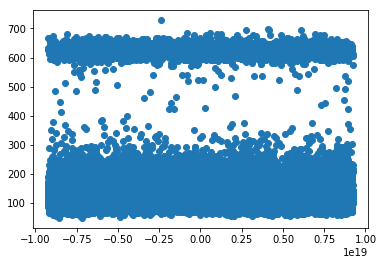

In [24]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [25]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 350), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(350, 550), TEXT].tolist()
len(outlier1), len(outlier2)

(62, 64)

In [26]:
df = df[df.enc_score <= 300]
len(df)

49758

In [ ]:
df = df.drop(['enc_score', 'str_len', 'new'], axis=1)
df.to_pickle(join(ETL_PATH, 'FAZ_combined.pickle'))
pd.read_pickle(join(ETL_PATH, 'FAZ_combined.pickle')).shape

### balanced sample of dataset (FAZ)

In [ ]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe().enc_score

In [ ]:
dfx.subset.head(25)

In [27]:
dfx.subset.to_pickle(join(ETL_PATH, 'FAZ_document_sample3.pickle'))

NameError: name 'dfx' is not defined

------

## preprocess FOCUS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
from collections import defaultdict
from constants import *

fname1 = 'FOCUS.pickle'
fpath1 = join(ETL_PATH, fname1)
df = pd.read_pickle(fpath1)

### Find bad encoded articles (FOCUS)

In [2]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
#bad = df.loc[5598736571409986456, TEXT]
#print(encryption_score(bad))

defaultdict(<class 'int'>, {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0})
[213, 172, 158, 238, 196, 181, 185, 116, 278, 96, 233, 195, 109, 148, 179, 174, 185, 225, 174, 153]


In [3]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

,text,enc_score
hash,,
-6271408166694537994,Beim Heizöl-Kauf ist das richtige Timing das A...,101
-7605027681485747078,Seit dem 1. Juli 2009 wird die Abgabe für neue...,199
8295392811760430332,"Von wegen, der Urlaub ist die schönste Zeit de...",216
-4612670798912085660,Seit dem Spanair-Unglück am 20. August 2008 si...,222
4362080969320069233,"Sie hat eiskalte Hände, eine Operationshaube a...",139
2151887591378696601,Metasuchmaschinen für Flugbuchungen liegen im ...,96
-3273469669028248336,"285 Küstenkilometer, 87 Sandbuchten: Auch wenn...",169
-1218625107520702511,In Deutschland gibt es unzählige Wohlfühl-Hote...,130
2973943744481446760,Sie sind auf der Suche nach einem neuen Smartp...,77


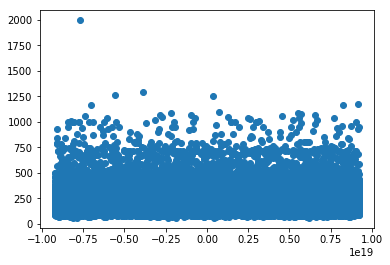

In [4]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [5]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(400, 3000), TEXT].tolist()
len(outlier1), len(outlier2)

(5758, 2122)

In [6]:
outlier2

['»Souveränität haben wir schon doppelzentnerweise in Brüssel abgeliefert.«ROMAN HERZOG',
 '1 Oceans Twelve (1)2. W.Regie: Steven Soderbergh, mit Brad Pitt, George Clooney, Julia Roberts. Besucher*: 294068/Gesamt: 1151023',
 'After the SunsetUSA 2004, Regie: Brett Ratner',
 'Switch!Von Christian Bieniek,Fischer Schatzinsel, 218 Seiten, 12,90 Euro',
 '--  Finanzielle Eckdaten des 3. Quartals:\n--  Unternehmen übertrifft Erwartungen in allen Profitabilitätskenngrößen seit fünf Quartalen in Folge\n--  Bereinigtes EBITDA von 32,4 Millionen USD einschließlich Korea im Jahresvergleich um 40% und sequenziell 12% gesteigert; Bereinigtes EBITDA von 28,1 Millionen USD aus fortgeführten Geschäften im Jahresvergleich um 45% und sequenziell um 9% höher --  Bereinigte EBITDA-Marge einschließlich Korea auf 18% von 16,1% im 2. Quartal 2015 gesteigert; Bereinigte EBITDA-Marge aus fortgeführten Geschäften auf 16,8% von 15,3% gesteigert --  Nicht-GAAP-konformer Gewinn pro Aktie einschließlich Korea von 0

In [7]:
df.groupby('subset').describe().enc_score

,count,mean,std,min,25%,50%,75%,max
subset,,,,,,,,
auto,3473.0,212.726461,86.172260,61.0,159.0,198.0,245.0,997.0
digital,8123.0,196.275145,70.968215,59.0,153.0,187.0,225.0,1013.0
finanzen,15989.0,200.326912,97.621318,57.0,149.0,183.0,224.0,1293.0
gesundheit,776.0,183.979381,64.691323,68.0,140.0,177.5,213.0,762.0
immobilien,737.0,167.568521,50.721678,80.0,131.0,161.0,198.0,583.0
kultur,20527.0,198.507575,82.224842,66.0,147.0,182.0,227.0,1266.0
panorama,16532.0,204.674571,74.746483,72.0,157.0,192.0,235.0,986.0
politik,22759.0,195.671910,69.705028,57.0,151.0,185.0,224.0,783.0
reisen,2601.0,191.392541,82.129233,70.0,144.0,176.0,221.0,1995.0


In [8]:
df = df[df.enc_score <= 300]
len(df)

86158

In [10]:
df = df.drop(['enc_score'], axis=1)
df.to_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle'))
pd.read_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle')).shape

(86158, 10)

### balanced sample of dataset (FOCUS)

In [12]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe()

doc_subid                                   
               count mean  std  min  25%  50%  75%  max
subset                                                 
auto          2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
digital       2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
finanzen      2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
gesundheit     743.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
immobilien     728.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
kultur        2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
panorama      2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
politik       2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
reisen        2000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
wissen        1183.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [13]:
dfx.subset.to_pickle(join(ETL_PATH, 'FOCUS_document_sample3.pickle'))

### apply cleansing to nlp dataframe

In [ ]:
# load
from os.path import join, isfile
from os import listdir
import pandas as pd
import numpy as np
from constants import *
pd.options.display.max_rows = 2001

corpus = 'FAZ_combined'
f = join(ETL_PATH, corpus + '.pickle')
dfetl = pd.read_pickle(f)
corpus = 'FOCUS_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlp = pd.read_pickle(f)

In [ ]:
# remove problematic formatted articles
ev = np.unique(dfetl.index.values)
nv = np.unique(dfnlp.hash.values)
print(ev.size, nv.size)
print((np.union1d(ev, nv)).size, (np.intersect1d(ev, nv)).size)

dfnlpx = dfnlp[dfnlp.hash.isin(ev)]
print(dfnlpx.shape, dfnlp.shape)
print(dfnlpx.groupby(HASH).head(1).shape)

In [ ]:
# save
corpus = 'FOCUS_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlpx.to_pickle(f)

-------

## preprocess Wikipedia

### collecting links from Wikipedia in a separate DataFrame

In [ ]:
# collecting links from Wikipedia in a separate DataFrame

from os.path import join, isfile
from os import listdir
import pandas as pd
from constants import *
import re

LINK_LIST = []
TAGS_LIST = []

def collect_links(df):
    for doc_id, links in df[LINKS].iteritems():
        for link in links:
            LINK_LIST.append((doc_id, *link))

def collect_tags(df):
    for doc_id, categories in df[TAGS].iteritems():
        for category in categories:
            TAGS_LIST.append((doc_id, category))

pattern = re.compile(r'^dewiki_\d')
files = sorted([f for f in listdir(FULL_PATH)
                if isfile(join(FULL_PATH, f))
                and pattern.match(f)
               ])

for name in files:
    fname = join(ETL_PATH, name)
    print(fname)
    df = pd.read_pickle(fname)
    collect_links(df)
    collect_tags(df)

del df
df_links = pd.DataFrame.from_records(LINK_LIST, columns=['doc_id', 'link', 'norm', 'category'])
del LINK_LIST
df_tags = pd.DataFrame.from_records(TAGS_LIST, columns=['doc_id', 'category'])
del TAGS_LIST
df_links.to_pickle(join(ETL_PATH, 'dewiki_links.pickle'))
df_tags.to_pickle(join(ETL_PATH, 'dewiki_categories.pickle'))

### splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline

In [ ]:
# splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline

from os.path import join
import pandas as pd
from constants import *

fname = 'dewiki_01.pickle'
fpath = join(ETL_PATH, fname)
df = pd.read_pickle(fpath)
split = 25*1000
#split *= 2
dfs = [df[:1*split], 
       #df[1*split:], 
       df[1*split:2*split], 
       df[2*split:3*split], 
       df[3*split:]
      ]
length = sum([len(d) for d in dfs])
assert len(df) == length
df.shape, [d.shape for d in dfs]
fsplit = fpath.rsplit('.', 1)
for i, d in enumerate(dfs):
    f = "{}_{:d}.{}".format(fsplit[0], i, fsplit[1])
    print(f)
    d.to_pickle(f)